# Import dependencies

In [1]:
import os
os.environ['DDE_BACKEND'] = "pytorch"

import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import pyvista as pv
pv.set_jupyter_backend("static")

device = torch.device("cuda")

Using backend: pytorch



In [2]:
def show_solution(u_func):
    # Input: scalar "u" to be displayed
    grid = pv.UniformGrid(dimensions=(150, 200, 1),
                          origin=(-0.5, -0.5, 0),
                          spacing=(0.01, 0.01, 0.01))
    
    u = u_func(grid.points)

    grid.point_data["u"] = u.flatten(order="F")
    
    plotter = pv.Plotter()
    plotter.add_mesh(grid)
    plotter.view_xy()
    plotter.show()

# Define governing equations

In [3]:
Re = 20
nu = 1 / Re
l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

In [4]:
def u_func(x):
    return 1 - np.exp(l * x[:, 0:1]) * np.cos(2 * np.pi * x[:, 1:2])


def v_func(x):
    return l / (2 * np.pi) * np.exp(l * x[:, 0:1]) * np.sin(2 * np.pi * x[:, 1:2])


def p_func(x):
    return 1 / 2 * (1 - np.exp(2 * l * x[:, 0:1]))

In [5]:
def pde(x, u):
    u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:]
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (
        u_vel * u_vel_x + v_vel * u_vel_y + p_x - 1 / Re * (u_vel_xx + u_vel_yy)
    )
    momentum_y = (
        u_vel * v_vel_x + v_vel * v_vel_y + p_y - 1 / Re * (v_vel_xx + v_vel_yy)
    )
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

# Define BC

In [6]:
def boundary_outflow(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

In [7]:
spatial_domain = dde.geometry.Rectangle(xmin=[-0.5, -0.5], xmax=[1, 1.5])

boundary_condition_u = dde.icbc.DirichletBC(
    spatial_domain, u_func, lambda _, on_boundary: on_boundary, component=0
)
boundary_condition_v = dde.icbc.DirichletBC(
    spatial_domain, v_func, lambda _, on_boundary: on_boundary, component=1
)
boundary_condition_right_p = dde.icbc.DirichletBC(
    spatial_domain, p_func, boundary_outflow, component=2
)

data = dde.data.PDE(
    spatial_domain,
    pde,
    [boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    num_domain=2601,
    num_boundary=400,
    num_test=100000,
)

# Network

In [8]:
net = dde.nn.FNN([2] + 4 * [50] + [3], "tanh", "Glorot normal")

TypeError: __init__() missing 1 required positional argument: 'kernel_initializer'

In [9]:
model = dde.Model(data, net)

In [16]:
net._output_transform is None

True

# Train Adam

In [14]:
ckpt_path = Path("models/onlyadam/ckpt")
ckpt_path.mkdir(parents=True, exist_ok=True)

loss_path = Path("models/onlyadam/loss")
loss_path.mkdir(parents=True, exist_ok=True)

In [10]:
# train with adam
model.compile("adam", lr=1e-3)
checkpointer = dde.callbacks.ModelCheckpoint(ckpt_path / "ckpt",
                                             verbose=1,
                                             save_better_only=True)

losshistory, train_state = model.train(iterations=30000, callbacks=[checkpointer])

Compiling model...
'compile' took 0.000168 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.50e-02, 6.12e-02, 5.07e-02, 2.95e+00, 1.78e-01, 8.51e-02]    [2.50e-02, 6.19e-02, 5.16e-02, 2.95e+00, 1.78e-01, 8.51e-02]    []  
Epoch 1: train loss improved from inf to 3.35e+00, saving model to models/onlyadam/ckpt-1.pt ...

1000      [1.82e-02, 6.40e-03, 7.37e-03, 7.12e-02, 2.78e-02, 4.37e-04]    [1.27e-02, 4.32e-03, 5.88e-03, 7.12e-02, 2.78e-02, 4.37e-04]    []  
Epoch 1000: train loss improved from 3.35e+00 to 1.31e-01, saving model to models/onlyadam/ckpt-1000.pt ...

2000      [6.07e-03, 4.23e-03, 3.21e-03, 2.59e-02, 1.18e-02, 4.19e-04]    [4.02e-03, 2.82e-03, 2.43e-03, 2.59e-02, 1.18e-02, 4.19e-04]    []  
Epoch 2000: train loss improved from 1.31e-01 to 5.16e-02, saving model to models/onlyadam/ckpt-2000.pt ...

3000      [6.73e-03, 3.50e-03, 2.31e-03,

Saving loss history to models/onlyadam/loss/loss ...


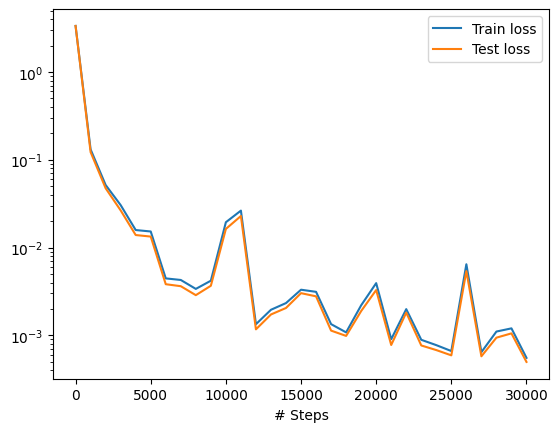

In [16]:
dde.utils.external.save_loss_history(loss_history=losshistory, fname=loss_path / "loss")
dde.utils.external.plot_loss_history(loss_history=losshistory)

# Train L-BFGS

In [ ]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Loss & Inference

In [20]:
X = spatial_domain.uniform_points(100000)

output = model.predict(X)
u_pred = output[:, 0]
v_pred = output[:, 1]
p_pred = output[:, 2]

u_exact = u_func(X).reshape(-1)
v_exact = v_func(X).reshape(-1)
p_exact = p_func(X).reshape(-1)

f = model.predict(X, operator=pde)

l2_difference_u = dde.metrics.l2_relative_error(u_exact, u_pred)
l2_difference_v = dde.metrics.l2_relative_error(v_exact, v_pred)
l2_difference_p = dde.metrics.l2_relative_error(p_exact, p_pred)
residual = np.mean(np.absolute(f))

print("Mean residual:", residual)
print("L2 relative error in u:", l2_difference_u)
print("L2 relative error in v:", l2_difference_v)
print("L2 relative error in p:", l2_difference_p)

Mean residual: 0.0079963235
L2 relative error in u: 0.0046862364
L2 relative error in v: 0.019253293
L2 relative error in p: 0.006946357
